--- Fitting Prophet Model ---


23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing



--- Starting Cross-Validation ---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Cha


Cross-validation performance metrics (aggregated by Prophet):
          horizon          mse       rmse        mae      mape     mdape  \
0 0 days 03:00:00   483.438333  21.987231  16.927991  0.008826  0.005680   
1 0 days 04:00:00   589.454837  24.278691  18.802663  0.010299  0.008539   
2 0 days 05:00:00   821.460889  28.661139  23.829247  0.013062  0.011359   
3 0 days 06:00:00   908.159405  30.135683  26.342118  0.014000  0.013420   
4 0 days 07:00:00  2015.305399  44.892153  35.485651  0.017766  0.016128   

      smape  coverage  
0  0.008816     1.000  
1  0.010227     1.000  
2  0.012942     1.000  
3  0.013920     1.000  
4  0.017876     0.875  

--- Performance Metrics for Specific Horizons ---

Horizon: 1 hours
  MAE: 15.0019
  MSE: 371.0215
  RMSE: 19.2619
  R2 Score: 0.9972
  MAPE: 0.7445%

Horizon: 6 hours
  MAE: 25.2020
  MSE: 822.6153
  RMSE: 28.6813
  R2 Score: 0.9857
  MAPE: 1.2935%

Horizon: 12 hours
  MAE: 39.6706
  MSE: 3546.2440
  RMSE: 59.5503
  R2 Score: 0.9858

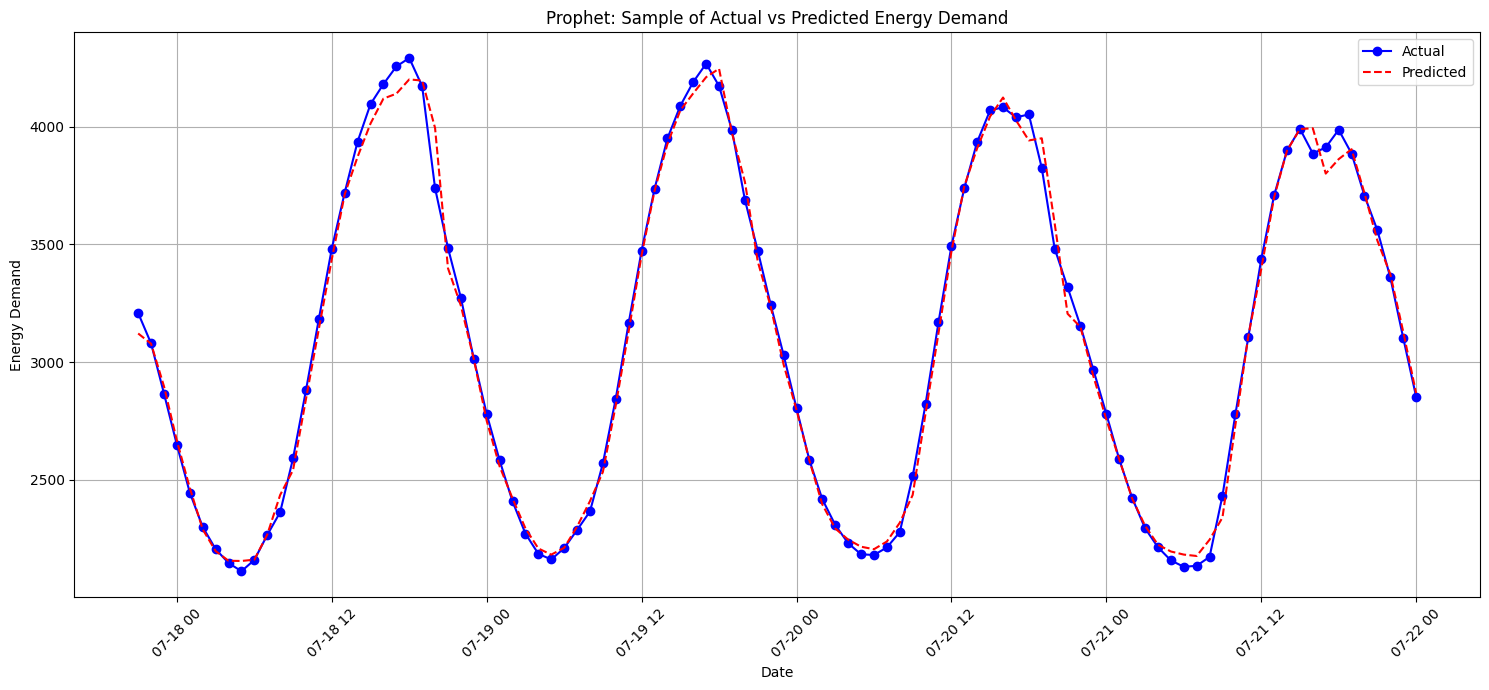


--- Plotting Prophet Components ---


KeyError: 'ds'

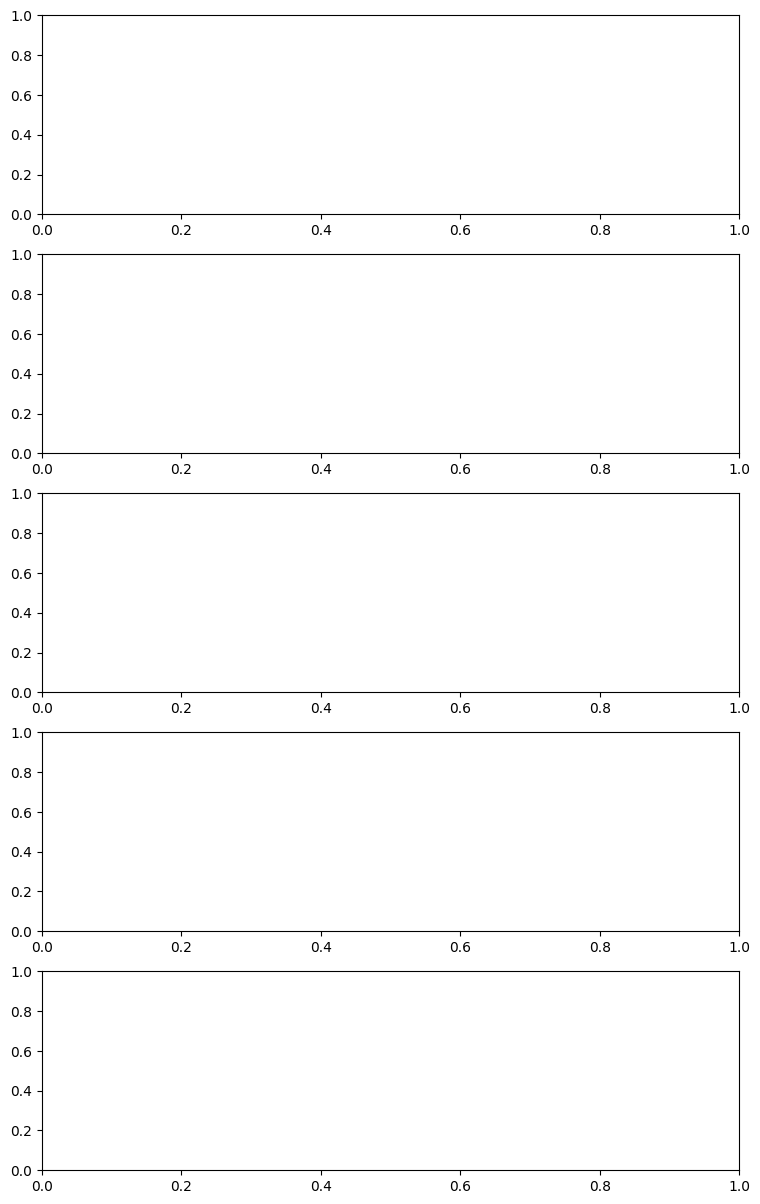

In [6]:
# Tampa Energy Demand Forecasting with Prophet (Updated & Corrected)
#
# This script uses Facebook's Prophet library for energy demand forecasting in Tampa.
#
# Updates:
# - Corrected a KeyError by manually calculating the 'horizon' column for metric evaluation.
# - Multi-Horizon Forecasting: Cross-validation is performed with a 24-hour horizon,
#   and performance metrics are calculated for 1, 6, 12, and 24-hour ahead forecasts.
# - Additional Metrics: Evaluation now includes MAE, MSE, RMSE, R², and a robust MAPE
#   for each specific forecast horizon.

#REMOVED TEMP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1. Data Loading and Feature Engineering ---
# Load the dataset
# Make sure to replace 'Tampa.csv' with the correct path if the file is not in the same directory.
try:
    data = pd.read_csv('Tampa.csv')
except FileNotFoundError:
    print("Error: 'Tampa.csv' not found. Please ensure the dataset is in the correct directory.")
    exit()

data.dropna(inplace=True)
data['time'] = pd.to_datetime(data['time'])
df = data.rename(columns={'time': 'ds', 'Demand (MW)': 'y'})

# Create time-based features
df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

# Create interaction features
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

# --- 2. Prophet Model Training ---
model = Prophet()

# Add regressors
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

print("--- Fitting Prophet Model ---")
model.fit(df)

# --- 3. Cross-Validation and Evaluation ---
print("\n--- Starting Cross-Validation ---")
# Perform cross-validation with a horizon that covers all our time steps
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='24 hours', parallel="processes")

# Display aggregated performance metrics from Prophet
df_p = performance_metrics(df_cv)
print("\nCross-validation performance metrics (aggregated by Prophet):")
print(df_p.head())

# Define a robust MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) == 0:
        return 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Calculate and display metrics for our specific horizons
print("\n--- Performance Metrics for Specific Horizons ---")
# FIX: Calculate the 'horizon' column manually from 'ds' and 'cutoff'
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_cv['horizon_hours'] = df_cv['horizon'].dt.total_seconds() / 3600
horizons = [1, 6, 12, 24]

for h in horizons:
    df_h = df_cv[df_cv['horizon_hours'] == h]
    if not df_h.empty:
        mae = mean_absolute_error(df_h['y'], df_h['yhat'])
        mse = mean_squared_error(df_h['y'], df_h['yhat'])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_h['y'], df_h['yhat'])
        mape = mean_absolute_percentage_error(df_h['y'], df_h['yhat'])

        print(f'\nHorizon: {h} hours')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  MAPE: {mape:.4f}%')
    else:
        print(f'\nNo data for horizon: {h} hours')


# --- 4. Final Forecast and Plotting ---
print("\n--- Generating Final Forecast and Plots ---")
future = df.drop(columns=['y'])
forecast = model.predict(future)

# Join forecast with actuals for plotting
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

# Plot a sample of the results
sample_period = 100
plt.figure(figsize=(15, 7))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b', marker='o')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r', linestyle='--')
plt.title('Prophet: Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
print("\n--- Plotting Prophet Components ---")
fig_components = model.plot_components(forecast)
plt.show()

